In [14]:
import numpy as np
import cv2
from jColor.Image import Image
from jColor.Color import Color
from scipy.stats import norm, gaussian_kde
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

In [15]:
plt.rcParams["font.family"] = "Nimbus Roman"
plt.rcParams["font.serif"] = "Nimbus Roman"

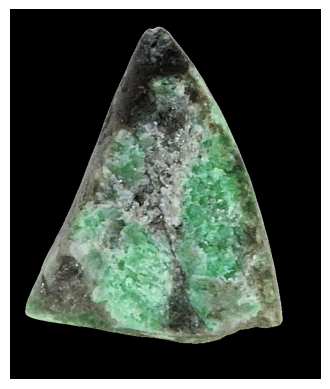

In [16]:
M = 'M1'
jImg = Image(f'imgs/{M}.jpg')
nJimg, wMean, bMask = jImg.RGB_Normalization()
plt.imshow(nJimg)
plt.axis('off')
plt.show()

[[77.21283599 77.21283599]
 [66.43434849 66.43434849]
 [40.67548317 40.67548317]]


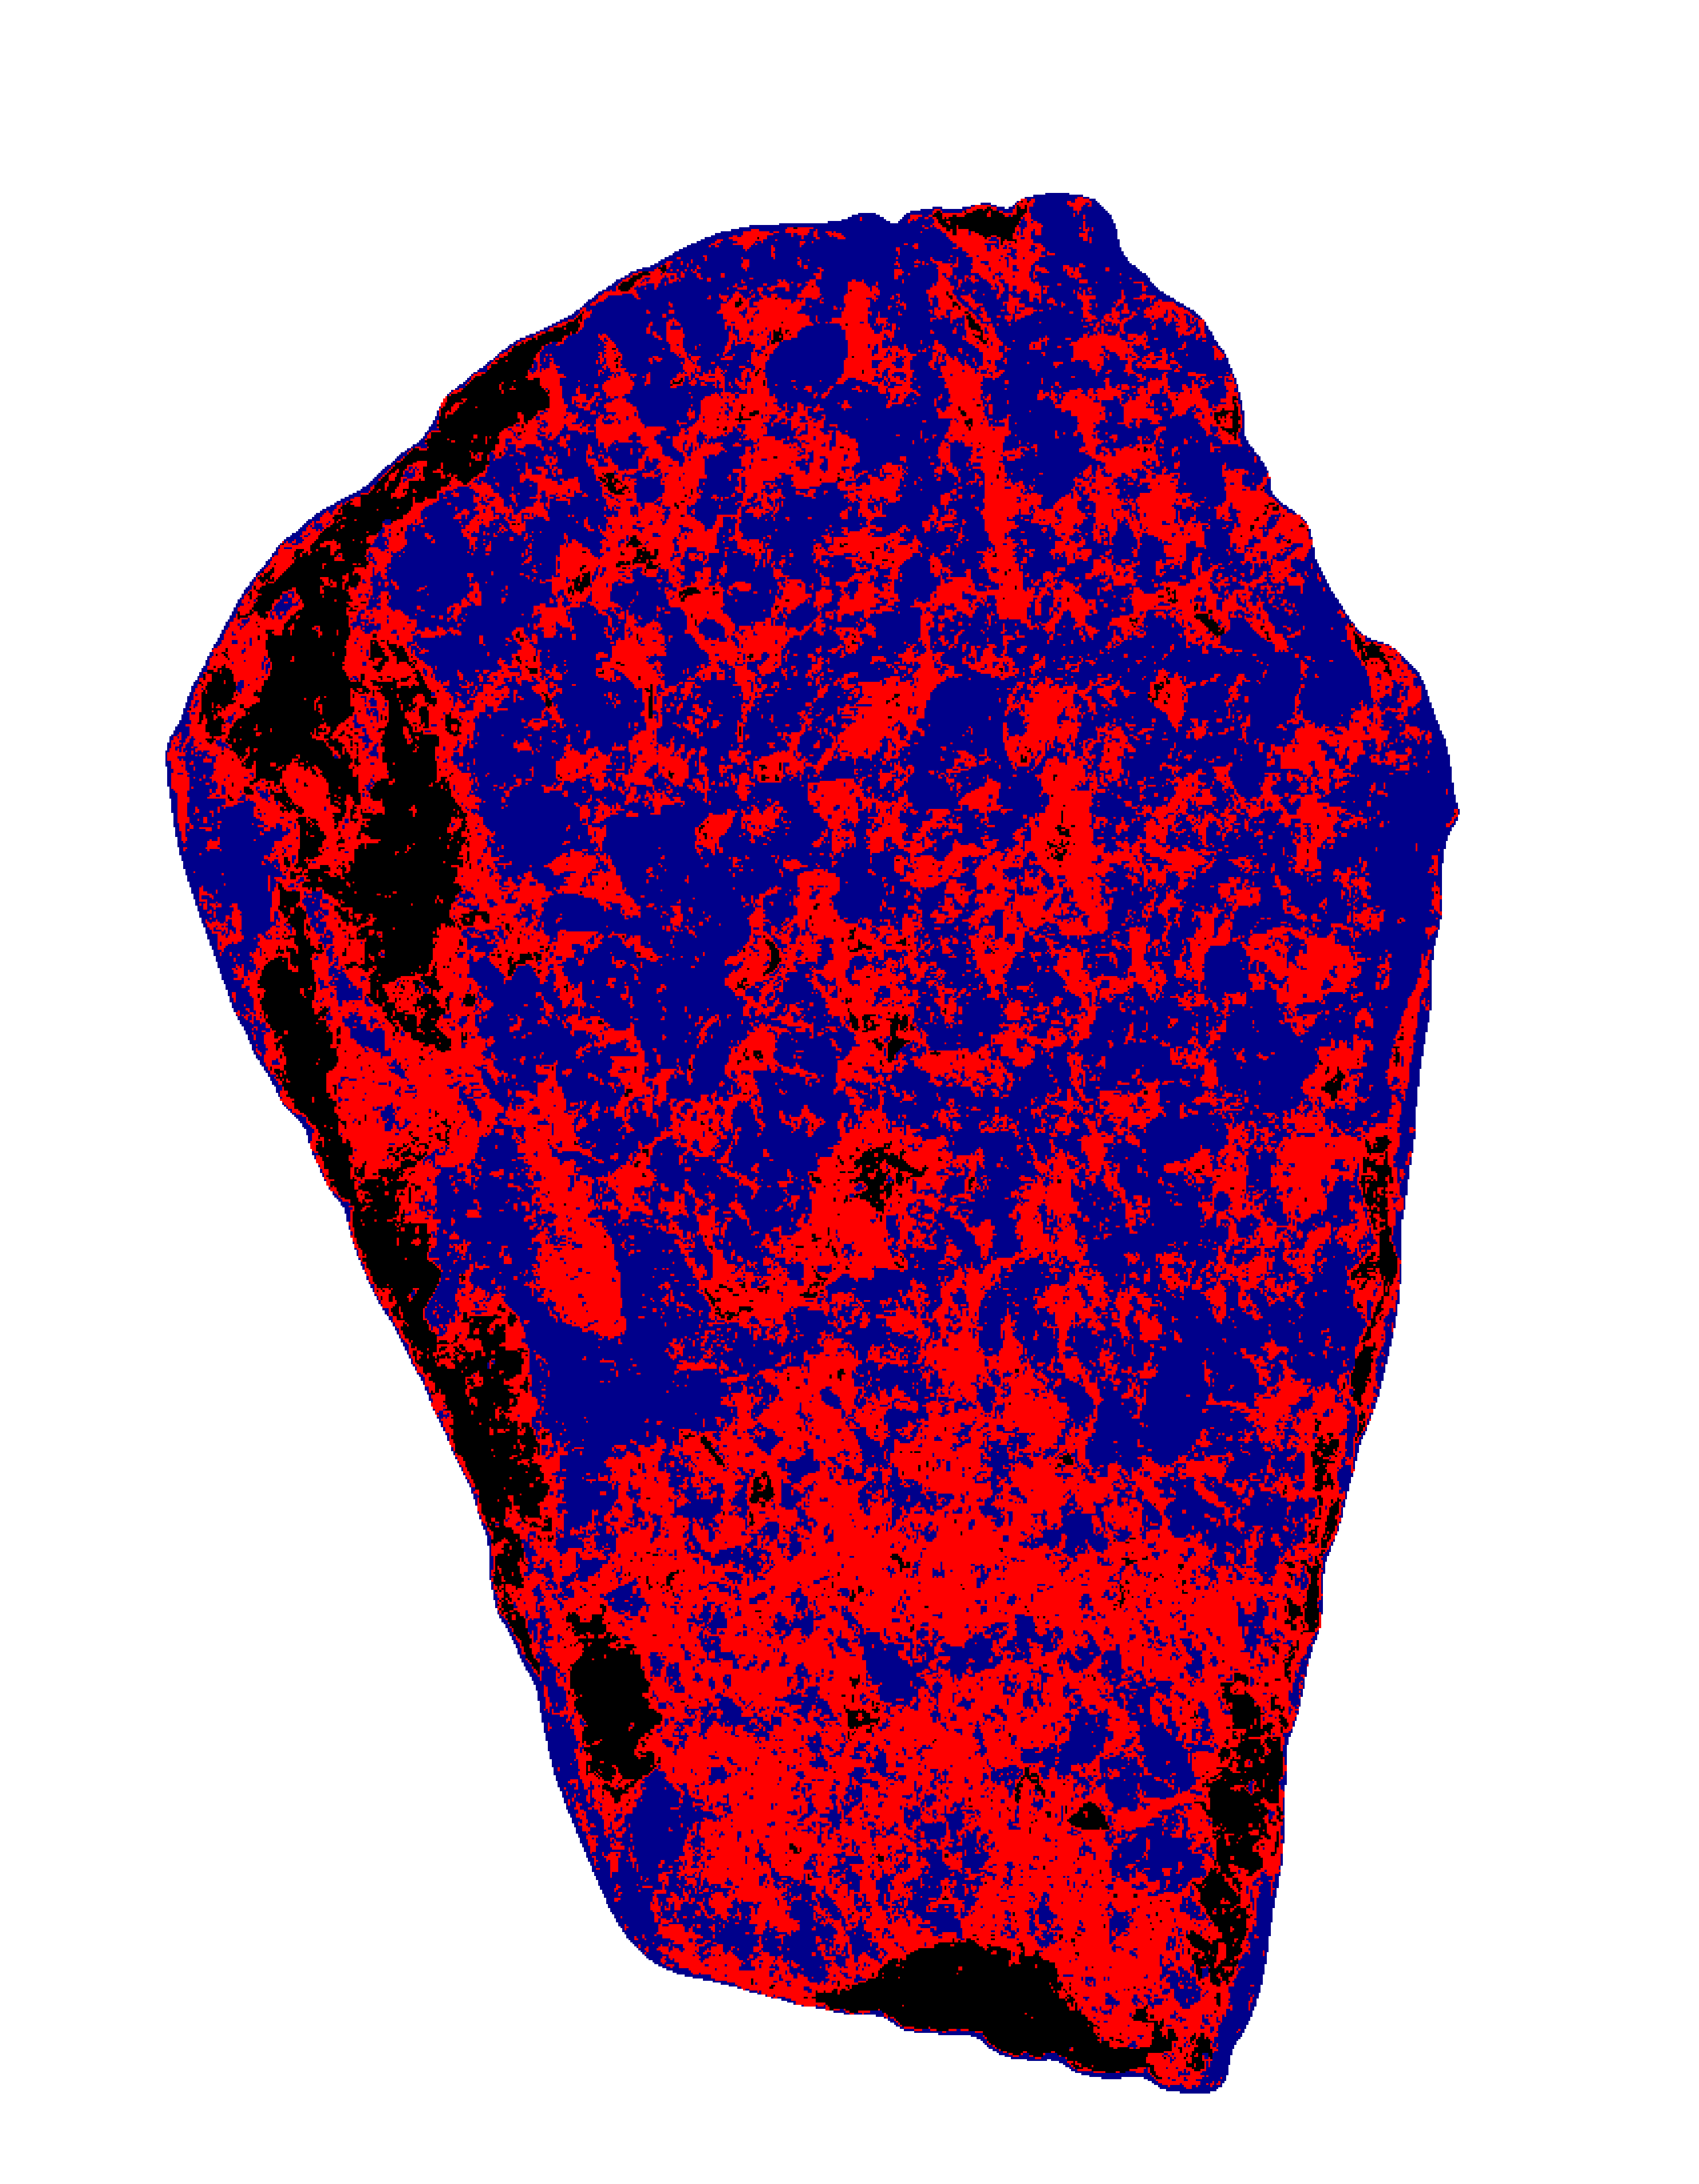

In [ ]:
pColor = Color(nJimg).Lab
LImg, aImg, bImg = cv2.split(pColor)
rows, columns = LImg.shape

data = np.column_stack((LImg[bMask != 0],LImg[bMask != 0]))
kmeans = KMeans(n_clusters = 3, init="k-means++",random_state=0,n_init=10)
kmeans.fit(data)
cls = np.sort(kmeans.cluster_centers_)

rMask = np.ones_like(LImg)*3
rMask[bMask != 0] = kmeans.labels_

colors = ['black','red','darkblue', 'white']  
colors = ['darkblue','red','black', 'white']
#colors = ['darkblue','black','red', 'white']  
cmap = ListedColormap(colors)
print(cls)

#plt.figure(figsize = (10,8),dpi = 600)
plt.imshow(rMask, cmap)
plt.axis('off')
plt.show()


100.0


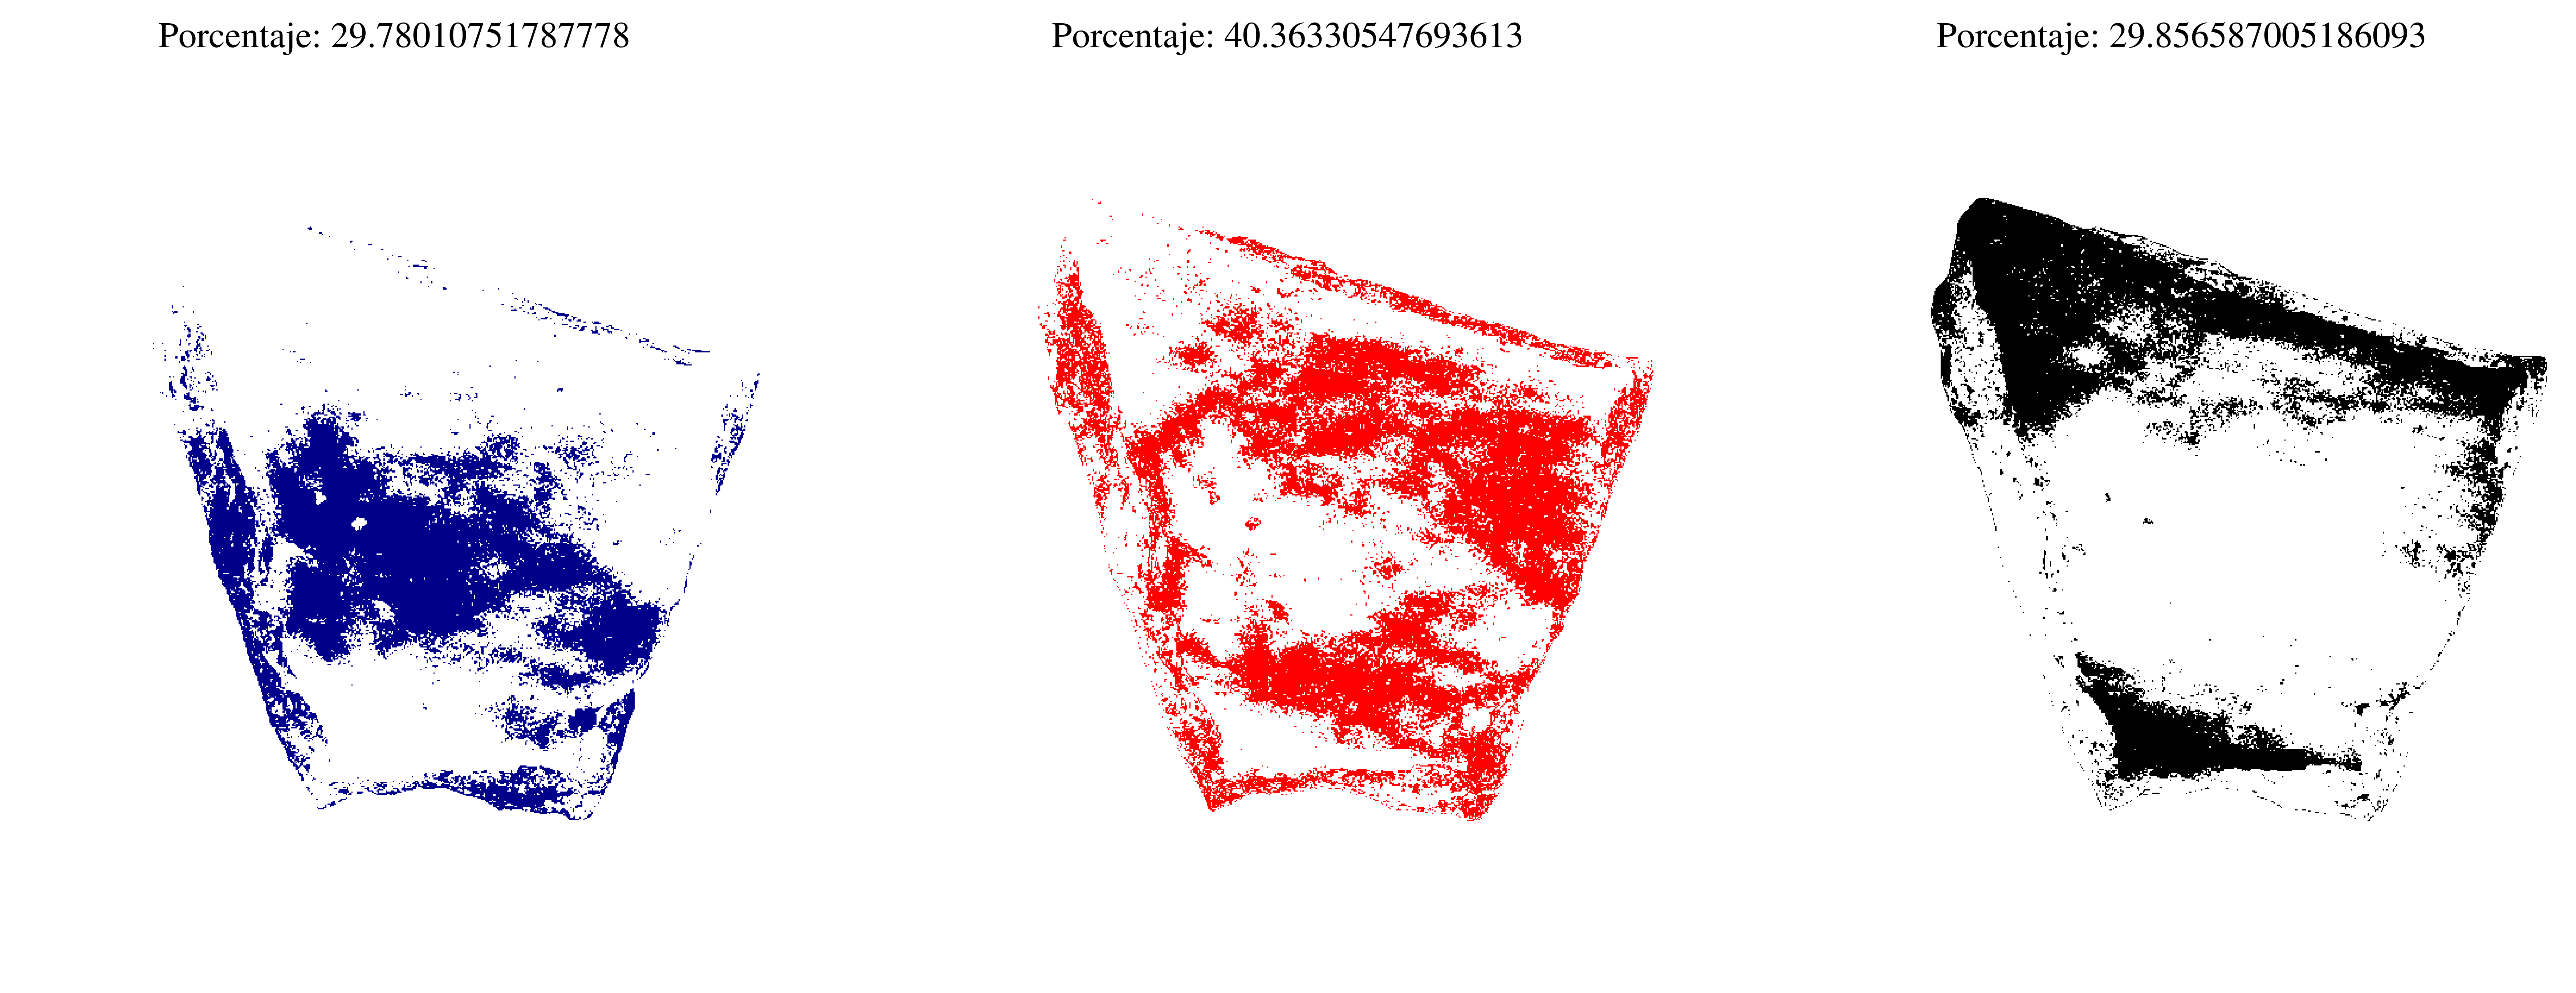

In [18]:
plt.figure(figsize = (15,10), dpi= 600)
total_ = 0

data = []
for i in range(3):
    
    bColors = ['white', colors[i]]
    bmap = ListedColormap(bColors)
    map_ = np.zeros_like(LImg)
    map_[rMask == i] =  1
    sLab = pColor[rMask == i]
    sample = np.sum(map_)
    total = np.sum(bMask)
    percent = (sample/total) * 100
    total_ += percent

    info = {'mean': sLab.mean(axis = 0),
            'std': sLab.std(axis  = 0),
            'max': sLab.max(axis = 0),
            'min': sLab.min(axis = 0),
            'var': sLab.var(axis = 0),
            'mse': (sLab.std(axis  = 0)/np.sqrt(len(sLab)))**2,
            'median': np.median(sLab,axis = 0),
            'percent':percent,
            'size_n': len(sLab)}
    
    data.append(info)


    plt.subplot(1,3,i+1)
    plt.title(f'Porcentaje: {percent}', fontname = 'Nimbus Roman')
    plt.imshow(map_,bmap)
    plt.axis('off')

print(total_)
plt.show()

In [34]:
samples = ['C','B','A']
#samples = ['C','A','B']

with pd.ExcelWriter('datos_M4_LL.xlsx') as writer:
    for i,s in enumerate(data):
        df = pd.DataFrame(s,index = ('L','a','b'))
        df.to_excel(writer,sheet_name = samples[i])


In [ ]:
cData = [LImg, aImg, bImg]
sheet_names = ['L','a','b']
with pd.ExcelWriter('datos_gauss_M4.xlsx') as writer:

    for k, aData in enumerate(cData):
        mean_ = np.array([i['mean'] for i in data])[:,k]
        std_ = np.array([i['std'] for i in data])[:,k]

        datos = []
                
        #colors = ['black','red','darkblue', 'white']  
        colors = ['darkblue','black',   'red', 'white']  

        Ldata = aData[bMask != 0]

        hist, bins = np.histogram(Ldata, bins=100, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        #plt.bar(bin_centers, hist, width=bins[1] - bins[0], alpha=0.6)
        x = np.linspace(np.amin(Ldata), np.amax(Ldata), 1000)

        kde = gaussian_kde(Ldata)
        density_real = kde(x)
        datos.append(x)
        datos.append(density_real)


        density_max = np.max(density_real)
        for i,m in enumerate(mean_):
            gauss_density = norm.pdf(x, m, std_[i])
            gauss_density_scaled = gauss_density * (density_real[np.argmax(gauss_density)] / np.max(gauss_density))
            #plt.plot(x, gauss_density_scaled,colors[i])
            datos.append(gauss_density_scaled)

        df = pd.DataFrame(np.array(datos).T,columns = ('x','Density','A','B','C'))
        df.to_excel(writer,sheet_name = sheet_names[k])